# Scalar Bilevel ROF
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-\bar{u}\|^2 + \beta\lambda\\
\text{s.t. } \hat{u} = arg\min_u \frac{1}{2}\|u-f\|^2+\lambda\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample to learn the optimal parameter for the ROF image denoising model.

In [1]:
using Pkg, Random, Images, TestImages, LinearAlgebra
using AbstractOperators
using StructuredOptimization

In [2]:
include("../BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [3]:
Random.seed!(123); # For reproductibility

## Load dataset

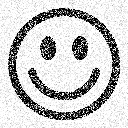

In [4]:
# Noisy image
Y = datasetimage("1_smiley_noisy","../datasets/smiley_dataset")
Y[Y .< 0] .= 0. # Make sure pixels are in range
Y[Y .> 1] .= 1.
Gray.(Y)

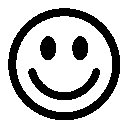

In [5]:
# Ground truth
Yt = datasetimage("1_smiley_original","../datasets/smiley_dataset")
Yt[Yt .< 0] .= 0. # Make sure pixels are in range
Yt[Yt .> 1] .= 1.
Gray.(Yt)

## Bilevel Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [6]:
# Minimizing the ROF dual formulation
function lower_level_solver(lambda,Y,V,U)
    @minimize ls(-V'*U+Y) + conj(lambda*norm(U,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    return Gray.(-V'*(~U)+Y)
end

# Upper level cost
function upper_level_cost(Yt,X,beta,lambda)
    return 0.5*norm(X-Yt) + beta*lambda^2
end

upper_level_cost (generic function with 1 method)

In [27]:
V = Variation(size(Y)) # Define the finite differences gradient operator
U = Variable(size(V,1)...)
beta = 0.1;

In [28]:
using Distributed

costs = Float64[]
@distributed for lambda in 0.0001:0.0001:4
    X = lower_level_solver(lambda,Y,V,U)
    push!(costs,upper_level_cost(Yt,X,beta,lambda))
    #println("The cost for $lambda of this iteration")
end


Task (done) @0x0000000133050010

In [37]:
# Saving generated data
using JLD
save("scalar_rof_cost.jld", "lambda", 0.0001:0.0001:4, "costs", costs)

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1242


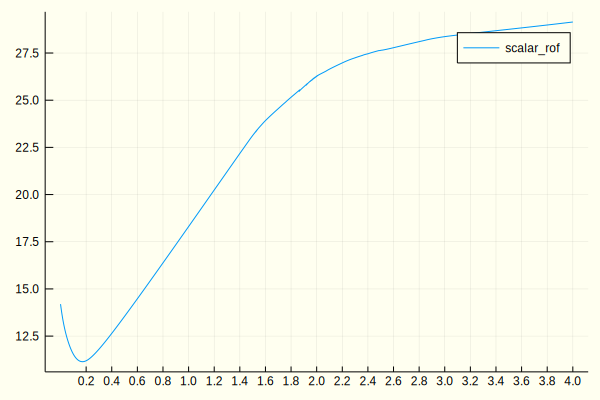

In [42]:
using Plots
d = load("scalar_rof_cost.jld")
plot(d["lambda"],d["costs"],label="scalar_rof",xticks = 0.2:0.2:4,background_color = :ivory)

## Gradient Calculation
In this section we will define a mechanism for calculated the gradient of the reduced functional
$$
f(\lambda) = J(S(\lambda),\lambda)
$$